# Fine Tuning Binary Classifiers
### Examples: Protest, John Legend, and Emotions

Andreu Casas and Nora Webb Williams | August, 2018

### Purpose:

To train binary visual classifiers predicting images with protesting crowds, with John Legend, and triggering sadness, enthusiasm, anger, disgust, and fear. A pre-trained Convolutinal Neural Net predicting the 1,000 ImageNet classes (ResNet18) is adpated to predict binary outcomes by replacing the last 1,000-weights fully-connected layer with a layer that has only 2 weights, then fine-tuning the parameters on new training data. The resulting models are saved in a './models/' directory. 

### Paths & Constants

In [46]:
# - in this data directory there are 7 folders, one with the train-test images of each classifier:
#     ['protest', 'legend', 'enthusiasm', 'anger', 'fear', 'sadness', 'disgust'].
#     Each of these directories has a 'train' and 'test' subdirectory, and each of these two
#     subdirectories has a 'negative' and 'positive' subsubdirectories with the True Negative and 
#     True Positive images to train each classifier.

"""
data
  |
  |
   - protest
  |        |
  |        |
  |         - train
  |        |      |
  |        |       - negative
  |        |      |
  |        |       - positive
  |         - test
  |               |
  |                - negative
  |               |
  |                - positive                  
  |
   - legend 
   (... etc.)
"""
 
# NOTE: WILL BE DIFFERENT ON PEOPLE's CLONED EC2 INSTANCE

# For instructors' demo
DATA_PATH = '/home/ubuntu/VPG/PROJECTS/cambridge_elements/data/'

# For cloned EC2 instance
#DATA_PATH = '/home/ubuntu/cambridge_elements/data/'

# - the path to a script with several FUNCTIONS we use in this script

# For instructors' demo
FUNCTIONS_PATH = '/home/ubuntu/VPG/PROJECTS/cambridge_elements/notebooks/'

# For cloned EC2 instance
#FUNCTIONS_PATH = '/home/ubuntu/cambridge_elements/notebooks/'

### Choices about which models to run and hyperparameters

In [47]:
# RESEARCHER CHOICES
# Which set of data do you want to train a model for? 
model_list = ['protest'] #Binary APSA 2018 options are 'protest', 'legend', 'enthusiasm', 'anger', 'fear', 'sadness', or 'disgust'

# Fine-tuning specification
num_classes = 2 # Enter the number of classes you are training for; will always be 2 for binary model
set_report_num = 1 # Enter how often you wish the program to report back as it iterates

# Hyperparameters
hyperparam_combo_num = 1 # Use this to keep track of which version of hyperparameters you are using 

set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
set_iterations = 5 # Enter the desired number of iterations
set_batch_size = 1 # Enter the desired batch size


### Modules

In [48]:
# Import all the needed python packages
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
plt.ion()   # interactive mode
import os
import pickle
import json
import pandas as pd
from PIL import Image

### Load Functions

In [49]:
# These are helper functions written by our team (mostly Andreu)
os.chdir(FUNCTIONS_PATH)
exec(open('00_functions.py', "rb").read())

### --MAIN-- Model Training

In [50]:
# MODEL TRAINING
# - a list of models to train, if not set by researcher above
if len(model_list) == 0:
	model_list = os.listdir(DATA_PATH)
	model_list = [m for m in model_list if m not in ['.DS_Store', 'MODELS', 'ACCURACY']]
	model_list.sort()

In [51]:
# Report which model is being trained
print(model_list)

['protest']


In [52]:
# Specifying some objects that will be the same for any model
# - preprocessing to be applied to the images. See '00_functions.py' script
#   for more details on the 'data_transform()' function,
#   which primarily standardized image size
preprocess = data_tranform()
# - checking if the machine has GPUs
use_gpu = torch.cuda.is_available()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.


In [53]:
# - how often (every how many iterations) should the loop print/report accuracy
report_num = set_report_num

# These lines are useful if you build a big loop around the classification;
# You can ignore for now. Note that model_str will be the name you entered in model_list
# Iterate through the datasets and build binary image classifiers.
counter_models = 0
total_models = len(model_list)
model_str = model_list[0]

In [54]:
#================================================================
# INITIALIZE MODEL
#================================================================
# - load a pretrained model from TorchVision: ResNet18
model = models.resnet18(pretrained=True)

# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features 

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet18, last step is 512 -> 2


In [55]:
#================================================================
# MODEL HYPER-PARAMETERS
#================================================================
# - specify some model hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(), 
                         lr=set_learn_rate, 
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer, 
                                       step_size=set_step_size, 
                                       gamma=set_gamma) # how to update learning rate    
# - number of iterations
iter_num = set_iterations

In [56]:
#================================================================
# PRE-PROCESSING
#================================================================
# - update counter and report progress
counter_models += 1
print('Training Model %s of %s: %s'%(counter_models, total_models, model_str.upper()))
print('=================================\n')

# - specify the path to data for this particular classifier
model_path = '%s/%s/'%(DATA_PATH, model_str)
# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x])
                  for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - specify whether to use gpu 
if use_gpu:
    model = model.cuda()

Training Model 1 of 1: PROTEST



In [57]:
#================================================================
# MODEL ESTIMATION
#================================================================
# - check the size of the train and test sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# - initialize a time object so we can check how long the training 
#   takes
since = time.time()

# - initialize a matrix of weights (model parameters) and accuracy
#   object where we'll save the weights and accuracy info for the
#   most accurate weights-configuration
best_model_wts = model.state_dict()
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
loss_progress = []  
acc_progress = []

# - 
for iteration in range(iter_num):
    if iteration % report_num == 0:
        print('Iteration {}/{}'.format(iteration, iter_num - 1))
        print('-' * 10)

    # - each iteration has a training and testing phase
    for phase in ['train', 'test']:
        if phase == 'train':
            scheduler.step() # update model weights
            model.train(True)  # set model to training mode
        else:
            model.train(False)  # set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # - iterate over data: in training iteration we
        #   iterate through groups of 4 train and 4 test
        #   images.
        for data in dataloaders[phase]:
            # - get the inputs
            inputs, labels = data

            # - transform data and labels into PyTorch variables
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # - gradients back to 0 (re-calculated in each iteration)
            optimizer.zero_grad()

            # - forward propagation: applying dot products
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            preds_int_list = list(preds)
            labels_int_list = list(labels.data)                
            loss = criterion(outputs, labels)

            # (only in training phase)
            # - backward propagation: calculate loss and gradients
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # - calculate accuracy statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)
            running_preds = running_preds + preds_int_list
            running_labels = running_labels + labels_int_list

        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]
        if sum(running_preds) > 0:
            iter_recall = sum([1 for i in range(0, len(running_preds)) if 
                                  running_preds[i] == 1 and 
                                  running_labels[i] == 1]) / float(sum(running_labels)) 
            iter_precision = sum([1 for i in range(0, len(running_preds)) if 
                                     running_preds[i] == 1 and 
                                     running_labels[i] == 1]) / float(sum(running_preds))
        else:
            iter_recall = 0
            iter_precision = 0

        # - report training progress once every N (e.g. 10) iterations
        if iteration % report_num == 0:
            print('{} Loss:{:.4f} Acc:{:.4f} Precision:{:.4f} Recall:{:.4f}\n'.format(
                phase, iter_loss, iter_acc, iter_precision, iter_recall))

        # - if this iteration's results are the best so far,
        #   saving a copy of this best model
        if phase == 'test' and iter_acc > best_acc:
            best_acc = iter_acc
            best_precision = iter_precision
            best_recall = iter_recall
            best_model_wts = model.state_dict()                
        if phase == 'test':
            # - keep track of the evolution of the loss and accuracy
            loss_progress.append(iter_loss)
            acc_progress.append(iter_acc)

    # - if the accuracy is already pretty high, move to next
    #   classifier
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... reached good model accuracy, moving to next model.')
        break

# - check how long it took to estimate the model and report
#   time and results for the most accurate model weights
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}\n\n'.format(best_acc))    

# - use the best model to predict labels for the whole
#   test set and calculate precision and recall of the
#   binary classifier   


# - save the best model weights and accuracy
model.load_state_dict(best_model_wts)
torch.save(model, '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))
accuracy_summary = {'acc':best_acc,
                      'precision':best_precision,
                      'recall':best_recall,
                      'lr':set_learn_rate,
                      'momentum':set_momentum,
                      'step_size':set_step_size,
                      'gamma':set_gamma,
                      'max_iters':set_iterations,
                      'batch_size':set_batch_size, 
                      'acc_progress':acc_progress,
                      'loss_progress':loss_progress
                      }
#json.dump(accuracy_summary, open('%s/ACCURACY/%s.json'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)), 'w'))

Iteration 0/4
----------
train Loss:0.1464 Acc:0.7000 Precision:0.6977 Recall:0.7059

test Loss:0.1118 Acc:0.8333 Precision:0.7778 Recall:0.9333

Iteration 1/4
----------
train Loss:0.1234 Acc:0.7824 Precision:0.7727 Recall:0.8000

test Loss:0.0861 Acc:0.9000 Precision:0.9286 Recall:0.8667

Iteration 2/4
----------
train Loss:0.1024 Acc:0.8471 Precision:0.8242 Recall:0.8824

test Loss:0.0692 Acc:0.9333 Precision:0.9333 Recall:0.9333

Iteration 3/4
----------
train Loss:0.0929 Acc:0.8412 Precision:0.8816 Recall:0.7882

test Loss:0.0746 Acc:0.8667 Precision:0.7895 Recall:1.0000

Iteration 4/4
----------
train Loss:0.0639 Acc:0.9000 Precision:0.9250 Recall:0.8706

test Loss:0.0516 Acc:0.9333 Precision:0.9333 Recall:0.9333

Training complete in 0m 34s
Best val Acc: 0.933333




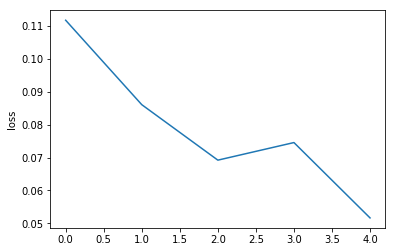

In [58]:
plt.plot(loss_progress)
plt.ylabel('loss')
plt.show()

### Take a look at some model predictions

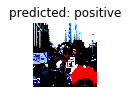

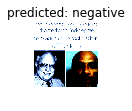

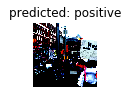

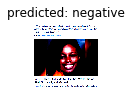

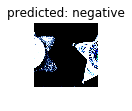

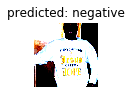

In [59]:
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

### Saving, loading, and using the trained model later

In [60]:
# - PyTorch comes with a function to easily save models
torch.save(model, '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))

In [61]:
# - now reload the model again
model_new = torch.load(
    '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))

In [62]:
# - load some example images to test how to use, on a new set of images, a model you previously trained
pos_path = '%s%s/test/positive/'%(DATA_PATH, model_str)
neg_path = '%s%s/test/negative/'%(DATA_PATH, model_str)
pos_list = ['%s%s'%(pos_path, x) for x in os.listdir(pos_path)[:5]]
neg_list = ['%s%s'%(neg_path, x) for x in os.listdir(neg_path)[:5]]
test_img_path_list = pos_list + neg_list
new_dataset = []
for img_file in test_img_path_list:
    img = Image.open(img_file).convert('RGB')
    new_dataset.append(img)

In [63]:
# - specifying the transformation-preprocessing to apply to the images
preprocess = data_tranform(train = False)

# - checking if the machine has GPUs and enabling GPU computing if so
use_gpu = torch.cuda.is_available()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [64]:
# - use the model to perform predictions on this "new" set of images
# ... initialize output dataset and a counter
output_data = pd.DataFrame()
counter = 0
total = len(new_dataset)
# ... iterate through the new images to predict
for z in range(0, len(new_dataset)):
    counter += 1
    print('image: %s/%s'%(counter, total))
    img_filename = test_img_path_list[z]
    img = new_dataset[z]
    # ... initialize output dict object for this iteration/img
    new_entry = {}
    # ... transform-preprocess this imags
    var = Variable(preprocess(img).unsqueeze(0))
    # ... make the model prediction
    pred = model_new(var.cuda())
    # ... pull the predicted class probabilities and create a dataframe with them
    probs, indeces = nn.Softmax(1)(pred).data.sort()
    probs = [round(x, 3) for x in list(probs[0])]
    indeces = list(indeces[0][:2])
    labels = [['negative', 'positive'][i] for i in indeces]
    pred_df = pd.DataFrame({'label':labels,
                            'probs':probs})
    pred_df_t = pred_df.transpose()
    final_pred_df = pd.DataFrame(pred_df_t.iloc[1]).transpose()    
    final_pred_df.columns = labels
    # ... adding some extra information about the image and prediction
    final_pred_df['img'] = '/'.join(img_filename.split('/')[-2:])
    final_pred_df['max_class'] = ['negative', 'positive'][indeces[1]]
    final_pred_df['max_pr'] = max(probs)
    output_data = pd.concat([output_data, final_pred_df])
output_data = output_data.reset_index(drop=True)

image: 1/10
image: 2/10
image: 3/10
image: 4/10
image: 5/10
image: 6/10
image: 7/10
image: 8/10
image: 9/10
image: 10/10


In [65]:
output_data

,img,max_class,max_pr,negative,positive
0,positive/53260.jpg,positive,0.978,0.022,0.978
1,positive/37456.jpg,positive,0.996,0.004,0.996
2,positive/50988.jpg,positive,0.977,0.023,0.977
3,positive/42512.jpg,positive,0.994,0.006,0.994
4,positive/52723.jpg,positive,0.960,0.04,0.96
5,negative/3019.jpg,negative,0.965,0.965,0.035
6,negative/7700.jpg,negative,0.974,0.974,0.026
7,negative/28559.jpg,negative,0.936,0.936,0.064
8,negative/7896.jpg,negative,0.965,0.965,0.035
9,negative/45130.jpg,negative,0.675,0.675,0.325
